# Point transfer in the third view using the trifocal tensor

In this example, we will find the corresponding point $\mathbf{x}_3$ in the third view based on the correspondences $\mathbf{x}_1 \leftrightarrow \mathbf{x}_2$ of the first and second view, using trilinear transfer with the trifocal tensor. As example, we will use a three-view system of two cameras and a projector: a camera as the first view, the projector as the second view, and another camera as the third view. A dataset of vertical and horizontal patterns projected onto a target of three circles will be used to estimate the circle centers coordinates in the third view.

We will first read our dataset, then we will detect circles' centers in both cameras with a center detector algorithm and in the projector using the projected patterns and the absolute phase. Finally, we will estimate in the third view the center coordinates with the trifocal tensor to compare it with the obtained by center detection in the image (ground truth). Then, let's obtain a list of the file name of images from both cameras with the projected patterns.

In [1]:
import glob
import os

# Root path of dataset
root = os.path.relpath('data/')

# List of file names of input images
imagesL = glob.glob(os.path.join(root,'L','*'))
imagesR = glob.glob(os.path.join(root,'R','*'))

## Real center coordinates estimation

As a first step, we'll estimate the center coordinates of the circles in the left and right cameras. The last image of the lists `imagesL` and `imagesL` are a texture image (with white light projection). We'll use those images for the center detector algorithm. The `target.py` file contains the center detector in the `detect` function. It returns a $3 \times 2$ array, where each row is the ($x$, $y$) of the center.

In [2]:
import cv2
import target

# Detect circle centers in left camera
imL = cv2.imread(imagesL[-1]) # The texture image is the last one in the list
cL = target.detect(imL.copy())

# Detect circle centers in right camera
imR = cv2.imread(imagesR[-1]) # The texture image is the last one in the list
cR = target.detect(imR.copy())

print('Left camera centers\n{}'.format(cL))
print('\nRigth camera centers\n{}'.format(cR))

Left camera centers
[[677.92736027 513.99979066]
 [616.20288887 696.77410836]
 [557.68914139 603.20627915]]

Rigth camera centers
[[559.04708131 615.25020269]
 [710.20602493 529.03834834]
 [611.19088271 708.73532809]]


Now, we need to undistort the previously detected points, and for that, we need to read the stereo calibration parameters between the cameras:

In [3]:
import numpy as np

# Load stereo calibration parameters
paramsLR = np.load(os.path.join(root,'camL_camR.npz')) # camL-camR params

# Undistort 2D center coordinates in each image (output points now are 3x1x2)
cL = cv2.undistortPoints(cL.reshape(-1,1,2), paramsLR['K1'], paramsLR['dist1'], None, None, paramsLR['K1'])
cR = cv2.undistortPoints(cR.reshape(-1,1,2), paramsLR['K2'], paramsLR['dist2'], None, None, paramsLR['K2'])

We need also to match points between both views. With `target.match` we can rearrange the rows of one of the matrix in order that the first point matches with the first of the second matrix and so on.

In [4]:
# Rearrange cR in order to match the points with cL
cR = target.match(cL, cR, paramsLR['F'])

# Convert points from Nx1x2 to Nx2
cL = cL[:,0,:]
cR = cR[:,0,:]

print('Left camera centers\n{}'.format(cL))
print('\nRigth camera centers\n{}'.format(cR))

Left camera centers
[[677.92824774 514.00011679]
 [616.1740741  696.97234614]
 [557.64983853 603.25308923]]

Rigth camera centers
[[710.20198967 529.03788827]
 [611.09840831 708.97902586]
 [558.95919486 615.33039   ]]


Plotting the texture images and the detected matched centers

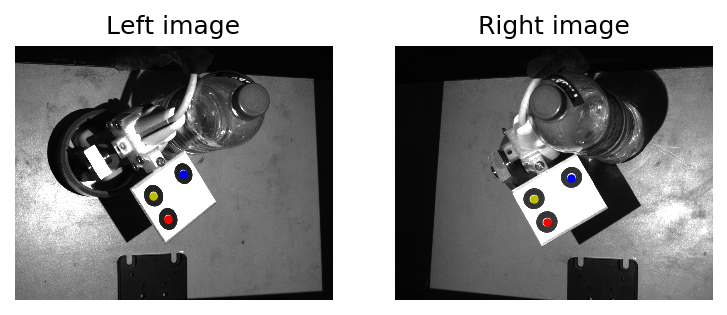

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,2,dpi=150)

# display left image
ax[0].imshow(imL), ax[0].axis('off')
# plot centers
ax[0].plot(cL[0,0],cL[0,1],'.b')
ax[0].plot(cL[1,0],cL[1,1],'.r')
ax[0].plot(cL[2,0],cL[2,1],'.y')
ax[0].set_title('Left image')

# display Right image
ax[1].imshow(imR), ax[1].axis('off')
# plot centers
ax[1].plot(cR[0,0],cR[0,1],'.b')
ax[1].plot(cR[1,0],cR[1,1],'.r')
ax[1].plot(cR[2,0],cR[2,1],'.y')
ax[1].set_title('Right image')

plt.show()

Now that we have the correspondences between cameras, we need to estimate the center coordinates in the projector. For that, 8 horizontal and 8 vertical fringes patterns are used, with vertical and horizontal centerline patterns all those patterns captured from the left camera. In this way, the vertical and horizontal absolute phase maps can be estimated within the target using a manually created mask.

Functions to aid the projector center estimation can be found in `fpp.py`. We'll use phase-shiting of 8 steps for wrapped phase estimation. Let's define some important parameters and read the stereo calibration parameters between the left camera and the projector, and the mask of the target in the left image needed for coordinates estimation:

In [6]:
import scipy.io as sio

# Phase-shifting steps and shifts
N = 8 # Total of steps used
delta = 2*np.pi*np.arange(1,N+1)/N # Shifts of each image

# Load stereo calibration parameters
paramsLP = np.load(os.path.join(root,'camL_proj.npz')) # camL-proj params

# Load mask for projector coordinates estimation with phase in left image
maskL = np.int32(sio.loadmat(os.path.join(root,'maskL.mat'))['maskL'])

Estimating the projector coordinates

In [7]:
import fpp

# Phase-shifting steps and shifts
N = 8 # Total of steps used
delta = 2*np.pi*np.arange(1,N+1)/N # Shifts of each image

# Estimate wrapped phase in x and y directions from images
phix, phiy = fpp.wrappedPhase(imagesL[2:10], imagesL[10:18], delta)

# Use centerline images to get init point for unwrapping (phase zero point)
p0 = fpp.seedPoint(imagesL[0], imagesL[1], maskL)

# Phase unwrapping with the zero-phase point (absolute phase)
Phix = fpp.spatialUnwrap(phix, p0, maskL)
Phiy = fpp.spatialUnwrap(phiy, p0, maskL)

# Estimate vertical phase values in the corners
c = fpp.polyfit2D(Phix, maskL, 5)
Phiv = fpp.polyval2D(cL[:,0], cL[:,1], c, 5)

# Estimate horizontal phase values in the corners
c = fpp.polyfit2D(Phiy, maskL, 5)
Phih = fpp.polyval2D(cL[:,0], cL[:,1], c, 5)

# Projector pixel coordinates of corners
cP = np.c_[12/(2*np.pi)*Phiv+1280/2-1,
           12/(2*np.pi)*Phih+800/2-1]

print('Projector centers estimated with left camera\n{}'.format(cP))

Projector centers estimated with left camera
[[638.83740185 369.92099355]
 [570.14100013 524.82831418]
 [519.09212114 446.13314512]]


In this way, in the following figure our three-view correspondences are shown:

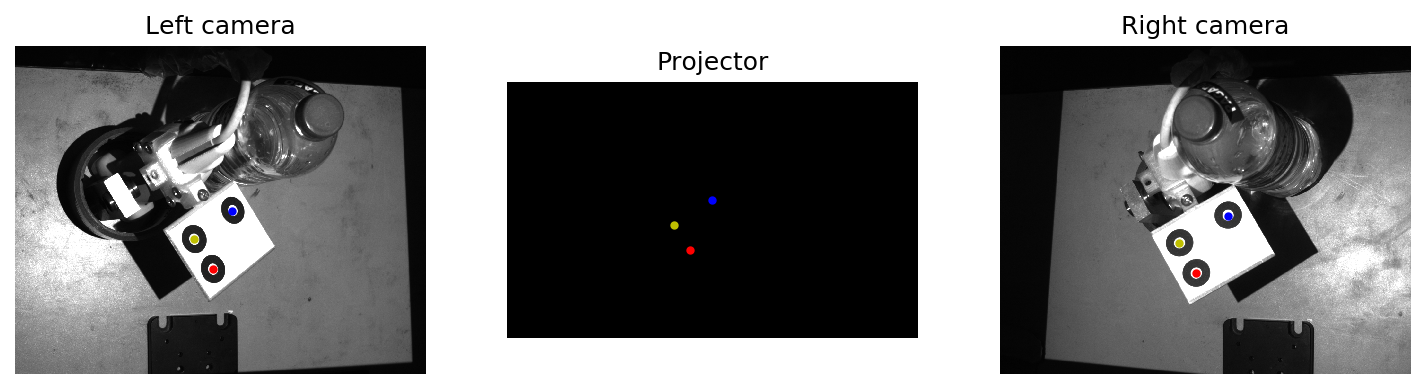

In [8]:
fig, ax = plt.subplots(1,3,figsize=(12,7), dpi=150)

# Left camera
ax[0].imshow(imL), ax[0].axis('off')
ax[0].plot(cL[0,0],cL[0,1],'.b')
ax[0].plot(cL[1,0],cL[1,1],'.r')
ax[0].plot(cL[2,0],cL[2,1],'.y')
ax[0].set_title('Left camera')

# Projector
ax[1].imshow(np.zeros([800,1280,3])), ax[1].axis('off')
ax[1].plot(cP[0,0],cP[0,1],'.b')
ax[1].plot(cP[1,0],cP[1,1],'.r')
ax[1].plot(cP[2,0],cP[2,1],'.y')
ax[1].set_title('Projector')

# Right camera
ax[2].imshow(imR), ax[2].axis('off')
ax[2].plot(cR[0,0],cR[0,1],'.b')
ax[2].plot(cR[1,0],cR[1,1],'.r')
ax[2].plot(cR[2,0],cR[2,1],'.y')
ax[2].set_title('Right camera')

plt.show()

The estimated coordinates `cL`, `cP`, and `cR` are our set of correspondences $\mathbf{x}_1 \leftrightarrow \mathbf{x}_2 \leftrightarrow \mathbf{x}_3$. And with `cL` and `cP`, we want to estimate the `cR` coordinates by point transfer usign the trifocal tensor.


## Trifocal tensor estimation

As our three-view system is calibrated, that is, as we now the projection matrices $\mathbf{P}_1$, $\mathbf{P}_2$, and $\mathbf{P}_3$ we can estimate the trifocal tensor using the expression


\begin{equation}
\label{trifocal_tensor}
\mathcal{T}_i^{jk} = (-1)^{i+1} \det \begin{bmatrix} \sim\!\!\mathbf{P}_1^i \\ \mathbf{P}_2^j \\ \mathbf{P}_3^k \end{bmatrix} \enspace,
\end{equation}

where $\mathbf{P}_r^s$ denote the $s$-th row of the $r$-th projection matrix, and $\sim \!\! \mathbf{A}^s$ denote a matrix $\mathbf{A}$ without the $s$-th row.

In [9]:
# Building the projection matrices
P1 = paramsLR['K1'] @ np.c_[np.eye(3), np.zeros(3)]
P2 = paramsLP['K2'] @ np.c_[paramsLP['R'], paramsLP['t']]
P3 = paramsLR['K2'] @ np.c_[paramsLR['R'], paramsLR['t']]

# Estimating the trifocal tensor
T = np.zeros([3,3,3])
for i in range(3):
    for j in range(3):
        for k in range(3):
            T[i,j,k] = (-1)**(i+1)*np.linalg.det(np.vstack([np.delete(P1,i,0), P2[j], P3[k]]))
    
T = T/np.linalg.norm(T) # Scale normalization
print('Trifocal Tensor\n{}'.format(T))

Trifocal Tensor
[[[ 5.16648566e-03 -2.23275899e-05  9.25226977e-08]
  [-1.18840713e-03  1.39564623e-04  2.58664889e-07]
  [-1.75515892e-06  1.63651391e-07  2.93575293e-10]]

 [[ 8.17590066e-04 -6.43740934e-03 -1.20122023e-07]
  [ 1.13811664e-02 -1.49287460e-03 -1.82650379e-06]
  [ 1.01010030e-06 -1.72181293e-07 -1.62036188e-10]]

 [[-2.99879804e-01 -7.58698942e-01 -7.64014627e-03]
  [-5.77905151e-01 -5.80103662e-03 -4.73038776e-04]
  [ 1.33397080e-02 -1.21086388e-03 -2.23994508e-06]]]


## Point transfer using the trifocal tensor

Given a pair of matches points in two views, we want to estimate the position of the points in the third view. Based on the correspondences $\mathbf{x}_1 \leftrightarrow \mathbf{x}_2$, with a line $\mathbf{l}_2$ passing through the point $\mathbf{x}_2$, we can estimate the corresponding point $\mathbf{x}_3$ by transferring the point $\mathbf{x}_1$ from the first to the third view with the expression

\begin{equation}
\label{transfer}
x_3^k = x_1^i l_{2j} \mathcal{T}_i^{jk} \enspace. \qquad \qquad \qquad (1)
\end{equation}

To select the line $\mathbf{l}_2$, we'll follow two approaches: the first is to use a vertical phase line in the projector (the $x_2$ coordinate in the projector corresponding to the point $\mathbf{x}_1$ computed with the vertical phase map). The second is to use an optimal strategy described in Multiple View Geometry in Computer Vision - H&Z (Section 15.3.2, page 381).


### Point transfer: first approach

As aforementioned, in this case we'll use the $x_2$ coordinate in the projector obtained with the absolute vertical phase map. A line $ax+by+c=0$ can be expressed in homogeneous coordinates as $\mathbf{l} = [a, b, c]^\mathsf{T}$. Then, our line in the projector can be expressed as $\mathbf{l}_2 = [-1, 0, x_2]^\mathsf{T}$. In case that you can use the $y_2$ coordinate of the projector $\mathbf{l}_2 = [0, -1, y_2]^\mathsf{T}$.

Based on Eq.(1) we have

In [10]:
x3 = np.array([])

# First center transfer
x = np.einsum('i,j,ijk -> k',np.r_[cL[0],1], np.array([-1,0,cP[0,0]]), T)
x3 = np.append(x3, x[:2]/x[-1])

# Second center transfer
x = np.einsum('i,j,ijk -> k',np.r_[cL[1],1], np.array([-1,0,cP[1,0]]), T)
x3 = np.append(x3, x[:2]/x[-1])

# third center transfer
x = np.einsum('i,j,ijk -> k',np.r_[cL[2],1], np.array([-1,0,cP[2,0]]), T)
x3 = np.append(x3, x[:2]/x[-1])

x3 = x3.reshape(-1,2)
print('Transfer estimation\n{}'.format(x3))

Transfer estimation
[[711.63326228 529.03246698]
 [612.41008414 709.00639367]
 [560.02163758 615.29748068]]


### Point transfer: second approach

The second approach, or the optimal transfer method, is the method recommended by H&Z. This consists of correct the pair matches $\mathbf{x}_1 \leftrightarrow \mathbf{x}_2$ with the fundamental matrix $\mathbf{F}_{21}$ between the left camera and the projector. They argue if the points $\mathbf{\hat{x}}_1$ and $\mathbf{\hat{x}}_2$ are exact matches the transferred point does not depend on the selected line $\mathbf{l}_2$ as long as it is not the epipolar line. A good choice is always given by the line perpendicular to the epipolar line $\mathbf{l}_{2e} = \mathbf{F}_{21} \mathbf{\hat{x}}_1$ in the second view.

The method is the following:

* Correct the matches $\mathbf{x}_1 \leftrightarrow \mathbf{x}_2$ to exact correspondences $\mathbf{\hat{x}}_1$ and $\mathbf{\hat{x}}_2$ with the algorithm 12.1 (page 318).
* Compute the line $\mathbf{l}_2$ through $\mathbf{\hat{x}}_2$ and perpendicular to $\mathbf{l}_{2e} = \mathbf{F}_{21} \mathbf{\hat{x}}_1$. If $\mathbf{l}_{2e} = [a_e, b_e, c_e]^\mathsf{T}$ and $\mathbf{\hat{x}}_2 = [\hat{x}_2, \hat{y}_2, 1]^\mathsf{T}$, then $\mathbf{l}_2 = [b_e, -a_e, -\hat{x}_2b_e + \hat{y}_2a_e]^\mathsf{T}$.
* Transfer the point as $x_3^k = \hat{x}_1^i l_{2j} \mathcal{T}_i^{jk}$.

In [11]:
# Unsing correctMatches to force epipolar constraint
x1h, x2h = cv2.correctMatches(paramsLP['F'], cL.reshape(1,-1,2), cP.reshape(1,-1,2))

# Epipolar line in the second view
l2e = cv2.computeCorrespondEpilines(x1h, 1, paramsLP['F'])
x1h = cv2.convertPointsToHomogeneous(x1h)

# Use a line perpendicular to the epipolar line l_2e
x3opt = np.array([])

# First center transfer
x = np.einsum('i,j,ijk -> k', x1h[0,0],np.array([l2e[0,0,1], -l2e[0,0,0], -x2h[0,0,0]*l2e[0,0,1]+x2h[0,0,1]*l2e[0,0,0]]),T)
x3opt = np.append(x3opt, x[:2]/x[-1])

# Second center transfer
x = np.einsum('i,j,ijk -> k', x1h[1,0],np.array([l2e[1,0,1], -l2e[1,0,0], -x2h[0,1,0]*l2e[1,0,1]+x2h[0,1,1]*l2e[1,0,0]]),T)
x3opt = np.append(x3opt, x[:2]/x[-1])

# Third center transfer
x = np.einsum('i,j,ijk -> k', x1h[2,0],np.array([l2e[2,0,1], -l2e[2,0,0], -x2h[0,2,0]*l2e[2,0,1]+x2h[0,2,1]*l2e[2,0,0]]),T)
x3opt = np.append(x3opt, x[:2]/x[-1])

x3opt = x3opt.reshape(-1,2)
print('Optimal transfer estimation\n{}'.format(x3opt))

Optimal transfer estimation
[[710.52646259 529.04697251]
 [611.43242875 709.07037305]
 [559.01555028 615.28518097]]


## Verifying the results

You can compare the results with both approaches with the real points detected in the third view

In [12]:
print('Compare results with real points in the third view\n{}'.format(cR))

Compare results with real points in the third view
[[710.20198967 529.03788827]
 [611.09840831 708.97902586]
 [558.95919486 615.33039   ]]


Estimating an error between the transferred points with the two approaches and the real detected centers:

In [13]:
print('Distance to each point with first approach: {}'.format(np.linalg.norm(x3-cR,axis=1)))
print('Error with first approach: {}'.format(np.linalg.norm(x3-cR)))
print('\nDistance to each point with second approach: {}'.format(np.linalg.norm(x3opt-cR,axis=1)))
print('Error with with second approach: {}'.format(np.linalg.norm(x3opt-cR)))

Distance to each point with first approach: [1.43128288 1.31196131 1.06295228]
Error with first approach: 2.2135222391713847

Distance to each point with second approach: [0.32460005 0.34628595 0.07224812]
Error with with second approach: 0.48010306013139303


We can visualize with a plot the estimated points with the second approach

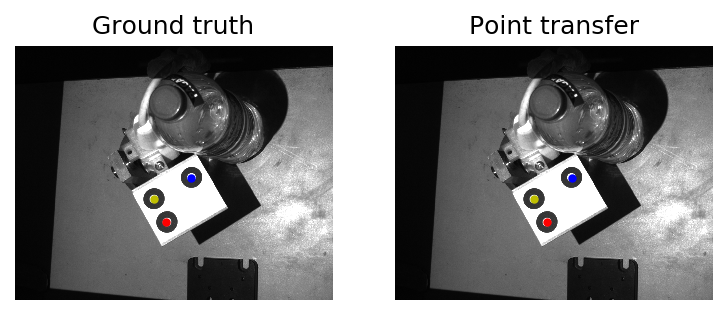

In [14]:
fig, ax = plt.subplots(1,2,dpi=150)

# display Right image with ground truth points
ax[0].imshow(imR), ax[0].axis('off')
ax[0].plot(cR[0,0],cR[0,1],'.b')
ax[0].plot(cR[1,0],cR[1,1],'.r')
ax[0].plot(cR[2,0],cR[2,1],'.y')
ax[0].set_title('Ground truth')

# display Right image with point transfer estimated points
ax[1].imshow(imR), ax[1].axis('off')
ax[1].plot(x3opt[0,0],x3opt[0,1],'.b')
ax[1].plot(x3opt[1,0],x3opt[1,1],'.r')
ax[1].plot(x3opt[2,0],x3opt[2,1],'.y')
ax[1].set_title('Point transfer')

plt.show()

As you can see, the estimated points look good.